# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [27]:
import os
import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

import pickle

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import sys

sys.path.append('/home/rzhou/Projects/timegan-pytorch/')

from models.timegan import TimeGAN
from models.utils import rescale
from data.data_preprocess import data_preprocess

%matplotlib inline

## Setting and Training

### Build dataset and settings

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/sines.yaml'
        self.save_dir = './toy_exp'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

### Training models

In [ ]:
trainer.train()

## Inference and Visualizations

### Sampling

In [ ]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy"))
fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_sines.npy'), fake_data)

### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

TimeGAN datas

In [2]:
path = "/home/rzhou/Projects/timegan-pytorch/output/rounD_09-23_seq250_nfea2_Epoch10000"
with open(f"{path}/train_data.pickle", "rb") as fb:
    ori_data = pickle.load(fb)
    # ori_data = ori_data.reshape(ori_data.shape[0]*ori_data.shape[1], ori_data.shape[2])
ori_data.shape

(3619, 250, 2)

In [3]:
# min_G_loss的pt生成的new_data
with open(f"{path}/fake_data.pickle", "rb") as fb:
    fake_data = pickle.load(fb)
    # new_data = new_data.reshape(new_data.shape[0]*new_data.shape[1], new_data.shape[2])

In [4]:
with open(f"{path}/args.pickle", "rb") as fb:
    args = torch.load(fb)
with open(f"{path}/fake_time.pickle", "rb") as fb:
    fake_time = pickle.load(fb)

fake_time = torch.tensor(fake_time, dtype=torch.float32)

data_path="/DATA1/rzhou/ika/single_testcases/rounD/rounD_single_09-23_seq250.csv"


epoch=3000#要改
model = TimeGAN(args)
model_path = "/home/rzhou/Projects/timegan-pytorch/output/rounD_09-23_seq250_nfea2_Epoch10000/min_G_loss_model_epoch_3000.pt"
model.load_state_dict(torch.load(model_path))
model.to(args.device)
model.eval()
with torch.no_grad():
    # Generate fake data
    Z = torch.rand((len(fake_time), args.max_seq_len, args.Z_dim))
    fake_data = model(X=None, T=fake_time, Z=Z, obj="inference").numpy()
fake_data.shape

(3619, 250, 2)

Diffusion-TS datas

In [28]:
import numpy as np
ori_data = np.load("/home/rzhou/Projects/Diffusion-TS/OUTPUT/rounD_map09-23_interval10_seq500_nfea10_pad-300/samples/rounD_map09-23_interval10_seq500_nfea10_pad-300_norm_truth_500_train.npy")
fake_data=np.load("/home/rzhou/Projects/Diffusion-TS/OUTPUT/rounD_map09-23_interval10_seq500_nfea10_pad-300/ddpm_fake_rounD_map09-23_interval10_seq500_nfea10_pad-300.npy")
print(ori_data)
print(ori_data.shape)
print(fake_data.shape)

[[[0.84864878 0.72987816 0.85610653 ... 0.         0.         0.        ]
  [0.84867587 0.72995347 0.85610584 ... 0.         0.         0.        ]
  [0.84870251 0.73003048 0.85610492 ... 0.         0.         0.        ]
  ...
  [0.87420397 0.77691177 0.9203504  ... 0.         0.         0.        ]
  [0.87459224 0.77721572 0.92009416 ... 0.         0.         0.        ]
  [0.87498671 0.77752238 0.91983355 ... 0.         0.         0.        ]]

 [[0.89901109 0.97332026 0.         ... 0.         0.         0.        ]
  [0.89896195 0.97318457 0.         ... 0.         0.         0.        ]
  [0.89891419 0.97305498 0.         ... 0.         0.         0.        ]
  ...
  [0.95798196 0.80849298 0.         ... 0.         0.         0.        ]
  [0.95899822 0.80820498 0.         ... 0.         0.         0.        ]
  [0.96001539 0.807899   0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [3]:
compare_len = ori_data.shape[0]
if compare_len>:  
    compare_len=5000 

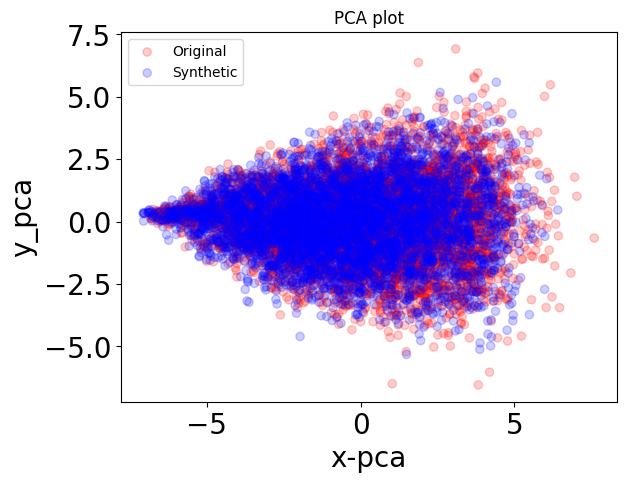

In [29]:

compare_len = ori_data.shape[0]
if compare_len>5000:
    compare_len=5000 
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=compare_len)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 0.534s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.694174
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.171173
[t-SNE] KL divergence after 300 iterations: 3.005213


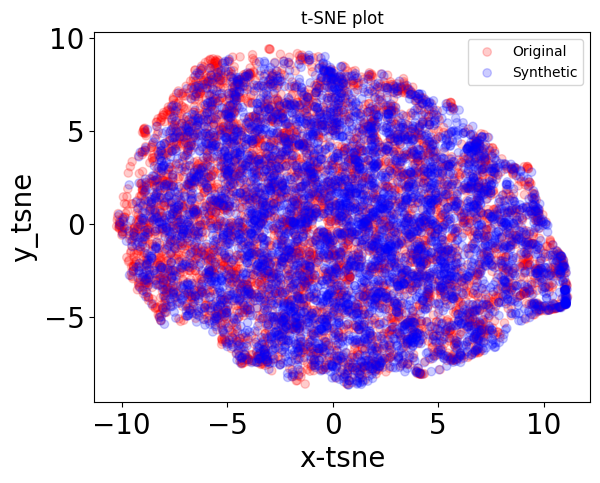

In [25]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=compare_len)

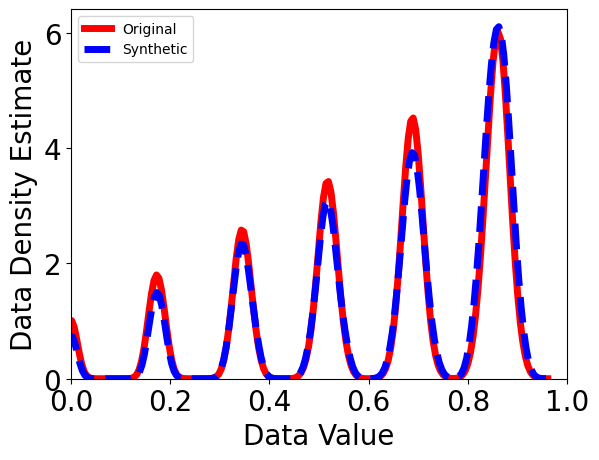

In [26]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=compare_len)